# Data Cleaning Notebook

## Objectives

*   Evaluate missing data
*   Clean data

## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv

## Outputs

* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned

## Conclusions

 
  * Data Cleaning Pipeline
  * Drop Variables:  `['customerID', 'TotalCharges' ]`



---


# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/walkthrough-churnometer/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/walkthrough-churnometer'

---

# Imports

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

%matplotlib inline

# Load Collected data

In [5]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/TelcoCustomerChurn.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1


# Data Exploration

In Data Cleaning you are interested to check the distribution and shape of a variable with missing data.

In [6]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['TotalCharges']

In [7]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlation and PPS Analysis

In [8]:
def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


Calculate Correlations and Power Predictive Score

In [9]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dt

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  419.0  0.113  0.172  0.0  0.0  0.0  0.156  0.777


/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dt

Display at Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



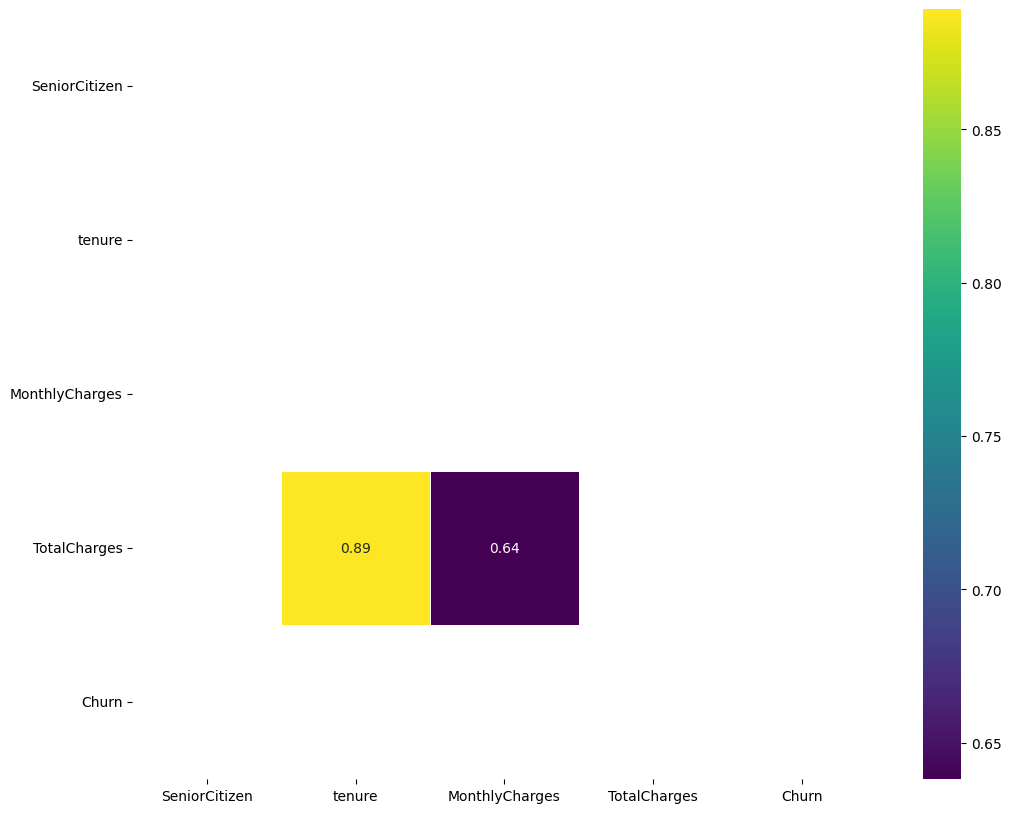

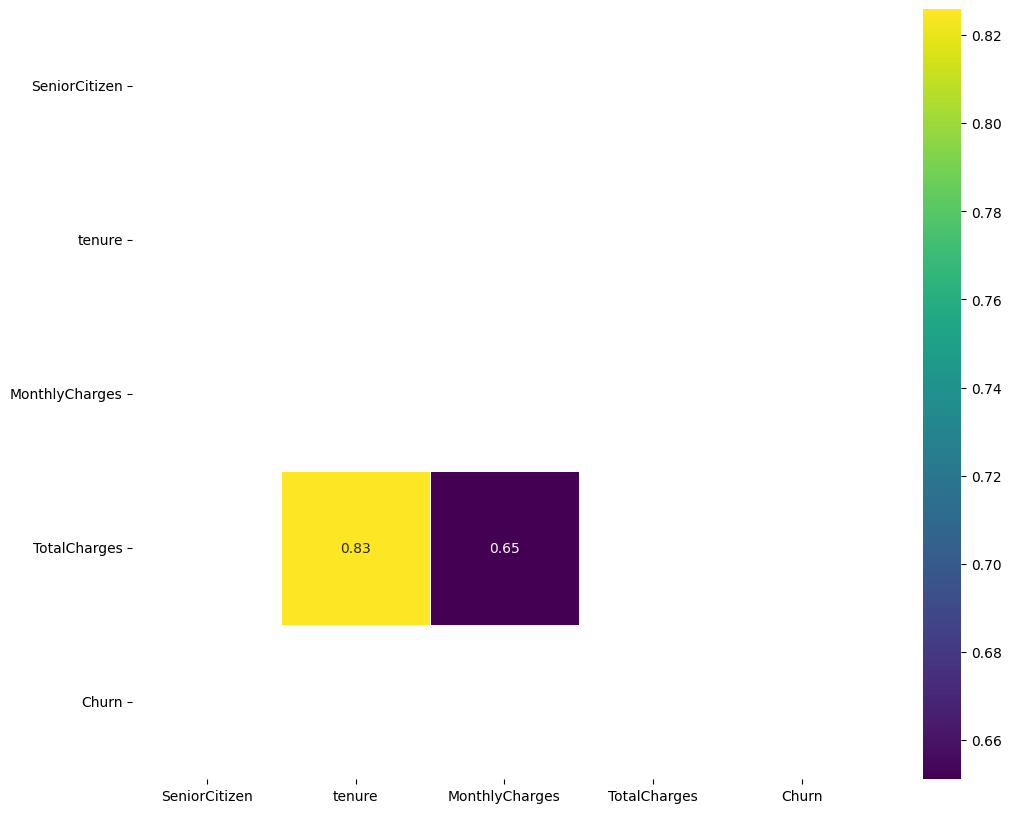

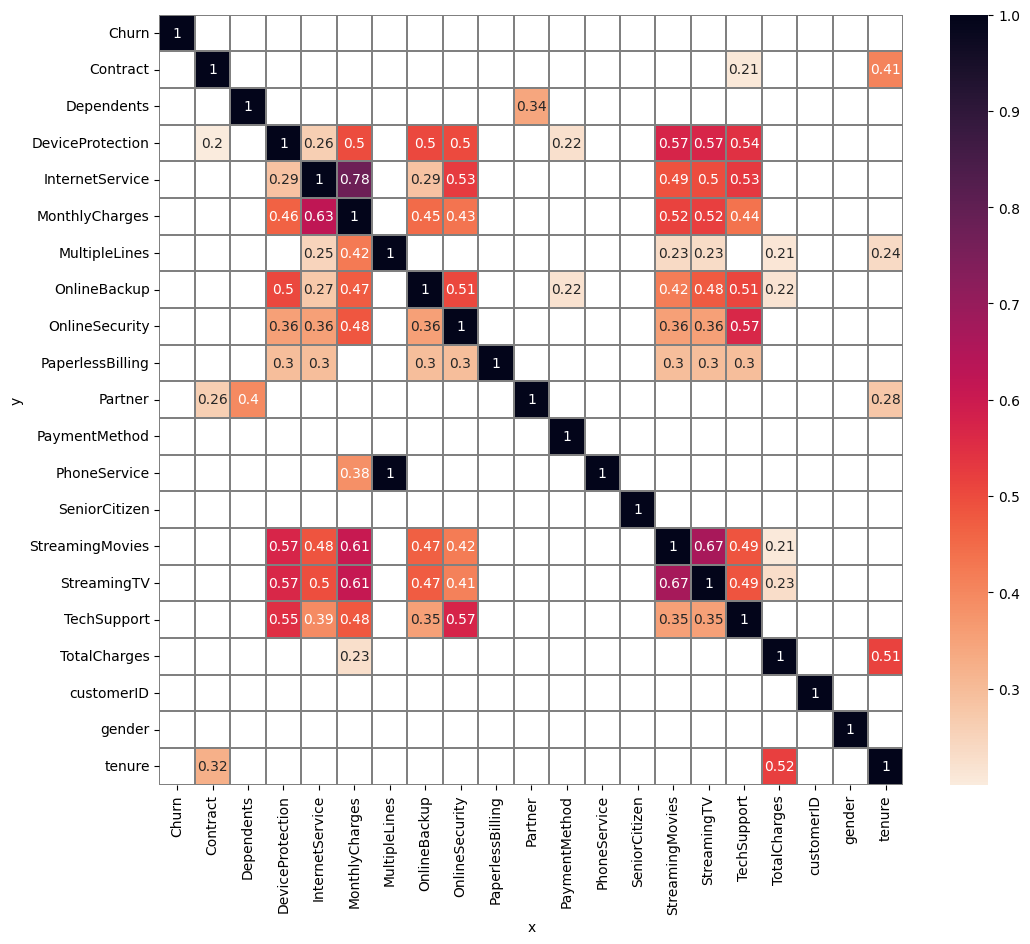

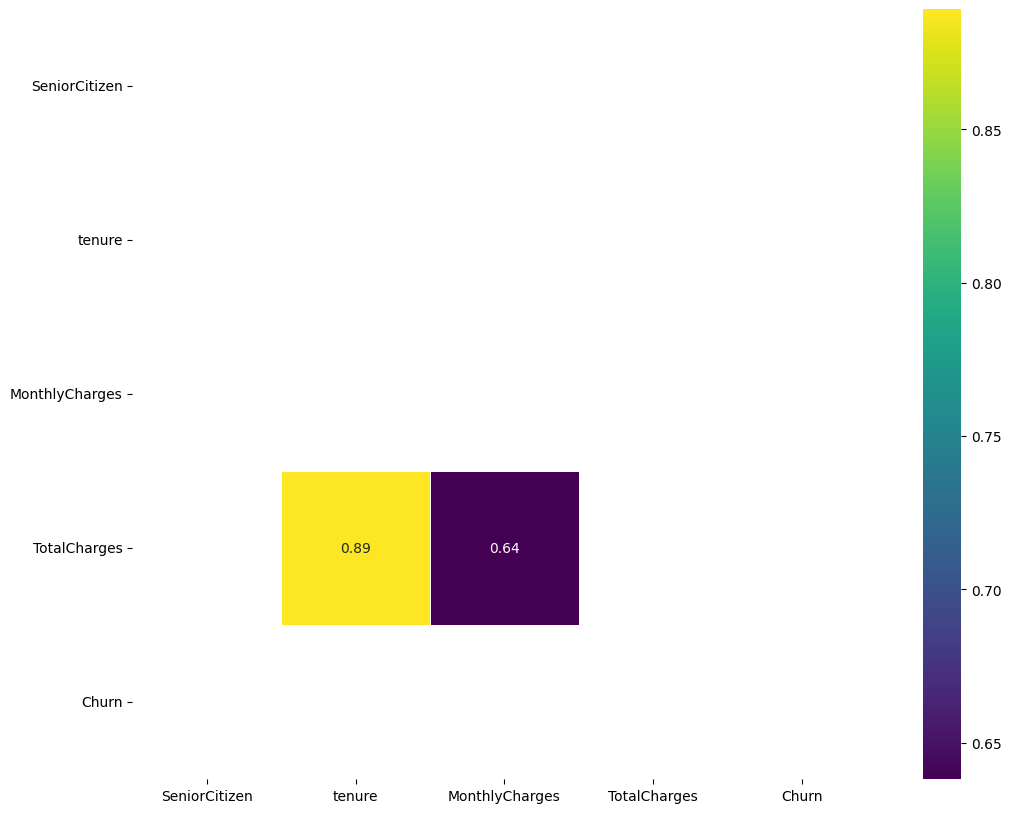



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



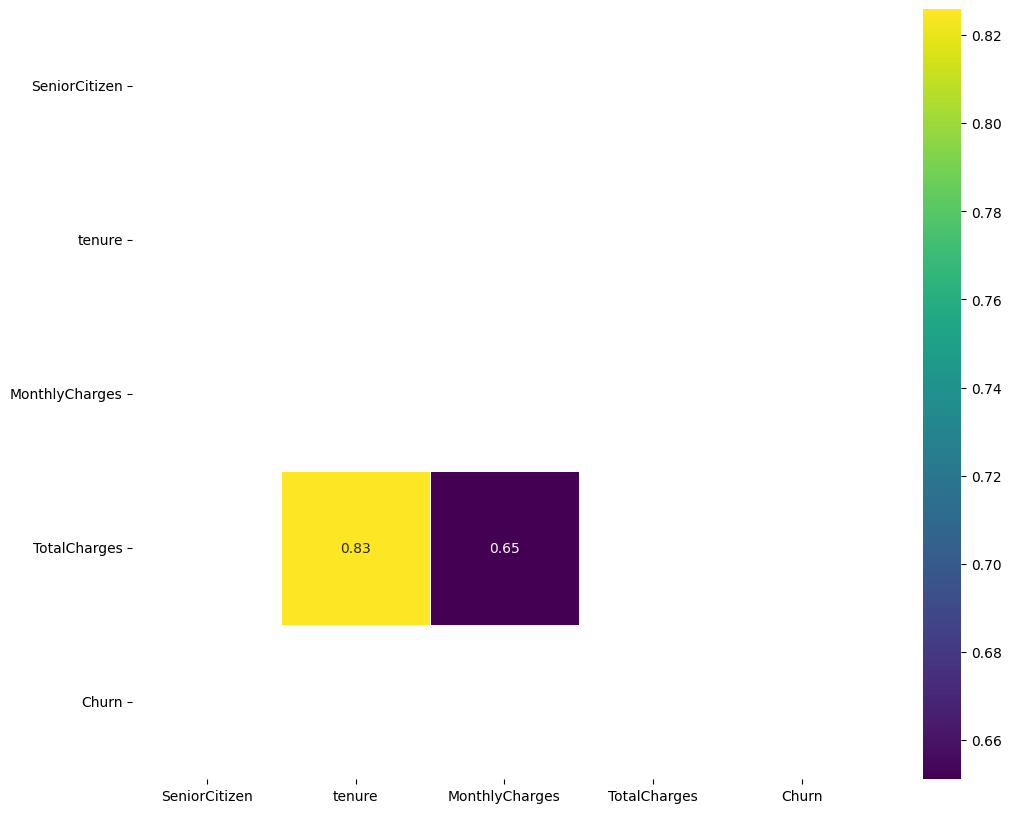



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



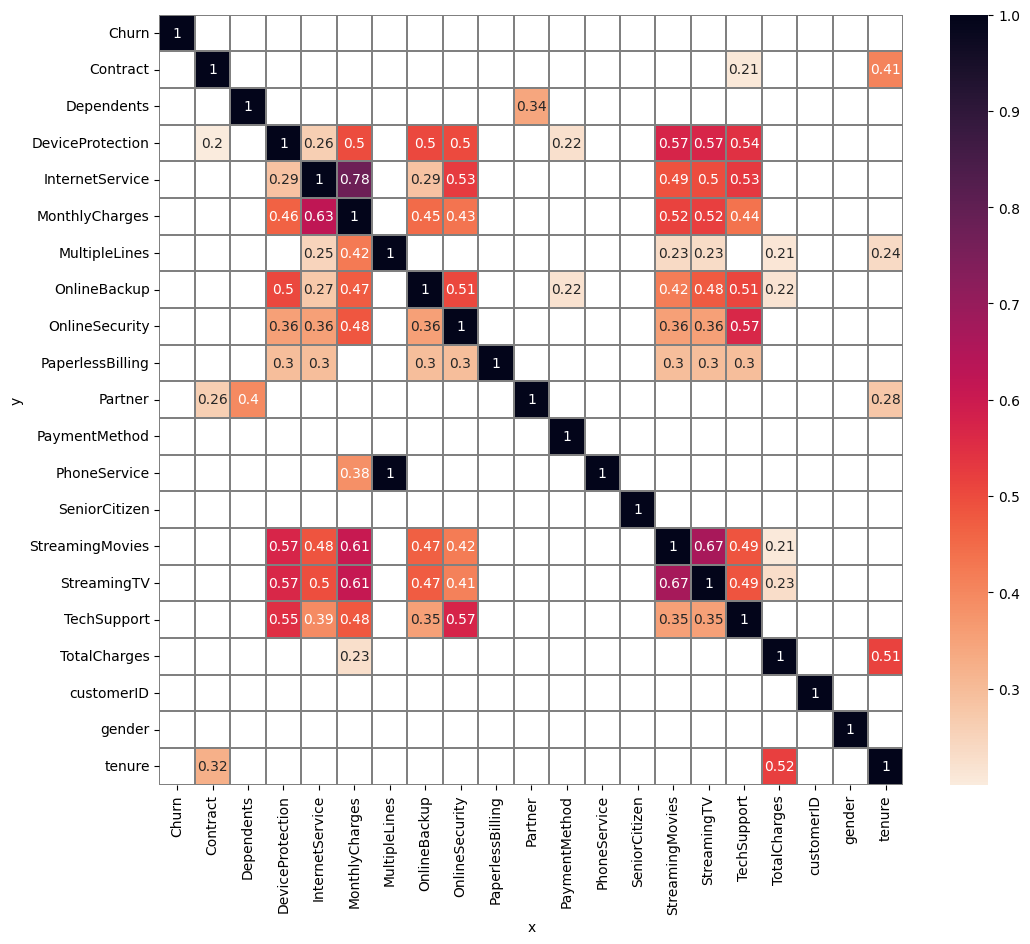

In [23]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

# Data Cleaning

## Assessing Missing Data Levels

* Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [24]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data


Check missing data levels for the collected dataset.

In [25]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
TotalCharges,11,0.16,float64


## Data Cleaning Spreadsheet Summary

* Consider your spreadsheet notes on potential approaches to handle missing data


## Dealing with Missing Data

This dataset doesn't require much data cleaning, therefore we are not loading the DataCleaningEffect() function we studied in the feature-engine lesson.
* For your future projects, this would be a moment to load that function and use it over your data-cleaning process.
* For this project, we are skipping this part.

### Data Cleaning Summary

List here the data cleaning approaches you want initially to try.
* Drop - `['customerID', 'TotalCharges' ]`


**The list above is your guide, your map to know at which stage you are in the data-cleaning process**

### Split Train and Test Set

In [26]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['Churn'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (5634, 21) 
TestSet shape: (1409, 21)


In [27]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 1 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
TotalCharges,8,0.14,float64


### Drop Variables


* Hint: you may drop Variables with more than 80% of missing data since these variables will likely not add much value. However, this is not the case in this dataset
* Step 1: imputation approach: **Drop Variables**
* Step 2: Select variables to apply the imputation approach


In [28]:
variables_method = ['customerID', 'TotalCharges' ]

print(f"* {len(variables_method)} variables to drop \n\n"
    f"{variables_method}")


* 2 variables to drop 

['customerID', 'TotalCharges']


* We are dropping `CustomerID` since it is a unique identifier for each customer, it doesn't add information to the dataset as it is.
* We are dropping `TotalCharges` as for the context of the ML projects, a prospect doesn't have `TotalCharges`.

* Step 3: Create a separate DataFrame applying this imputation approach to the selected variables.

In [30]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

* Step 4: Assess the effect on the variable's distribution.

* In this case, there is no effect on the distribution of the variable, since you are not removing rows, but columns.
* The effect might be losing features that might have a relevant impact on your machine-learning model.

* Step 5: If you are satisfied, apply the transformation to your data.

In [32]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

KeyError: "None of [Index(['customerID', 'TotalCharges'], dtype='object')] are in the [columns]"

* Step 6: Evaluate if you have more variables to deal with. If yes, iterate. If not, you are done.

In [33]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType


# Push cleaned data to Repo

In [34]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)


[Errno 17] File exists: 'outputs/datasets/cleaned'


## Train Set

In [35]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## Test Set

In [36]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)

Good job! Clear cell outputs

Well done! You can now push the changes to your GitHub Repo, using the Git commands (git add, git commit, git push)